In [1]:
from split_data import split
import numpy as np
import torch
from torchvision.datasets import ImageFolder
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

from utils import *
from convert_MLModel import convert_to_mlmodel


In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using {device}")

Using mps


In [3]:
source_path = "../Data/Augmentation/Grape"
training_path = "../train_data/Grape"
testing_path = "../test_data/Grape"
train_test_ratio = 0.7
split(source_path, training_path, testing_path, train_test_ratio) 

Finish splitting No_leaves
[Training Samples:800, Testing Samples:343]   Original Samples:1143
---------------------
Finish splitting Healthy
[Training Samples:700, Testing Samples:300]   Original Samples:1000
---------------------
Finish splitting Leaf_blight_(Isariopsis_Leaf_Spot)
[Training Samples:753, Testing Samples:323]   Original Samples:1076
---------------------
Finish splitting Esca_(Black_Measles)
[Training Samples:968, Testing Samples:415]   Original Samples:1383
---------------------
Finish splitting Black_rot
[Training Samples:826, Testing Samples:354]   Original Samples:1180
---------------------
Total Training Samples: 4047, Testing Samples: 1735, Total Samples: 5782


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


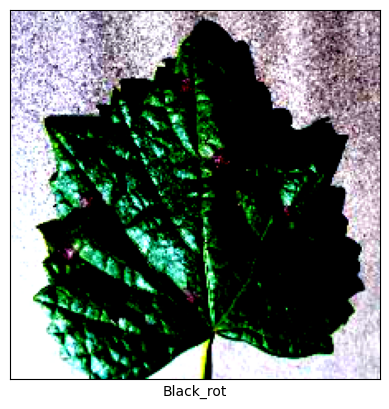

In [4]:
# -------------[transform into suitable size for transfer learning]--------------------
transformation = preprocess()

train_dataset = ImageFolder(training_path, transform = transformation)

test_dataset = ImageFolder(testing_path,transform = transformation)

classes = train_dataset.classes

#display the first image in the dataset
display_img(*train_dataset[0], classes)

In [5]:
classes

['Black_rot',
 'Esca_(Black_Measles)',
 'Healthy',
 'Leaf_blight_(Isariopsis_Leaf_Spot)',
 'No_leaves']

In [6]:
batch_size = 64
train_val_ratio = 0.8
val_size = int(np.round(len(train_dataset) * (1-train_val_ratio)))
train_size = len(train_dataset) - val_size 

train_data, val_data = random_split(train_dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_data, batch_size, num_workers = 4, pin_memory = True)

test_dl = DataLoader(test_dataset, batch_size, num_workers = 4, pin_memory = True)

Length of Train Data : 3238
Length of Validation Data : 809


### EfficientModel B0

In [8]:
efficient_model = load_efficient_net().to(device)

num_classes = len(classes)

efficient_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=num_classes, bias=True)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(efficient_model.parameters(), lr=0.001)

# efficientNet B0 model
efficient_results = train(model=efficient_model,
                train_dataloader=train_dl,
                val_dataloader=val_dl,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=10,
                device=device)

torch.save(efficient_model, "../Models/grape_efficient_model.pt")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6597 | train_acc: 0.8663 | train_f1: 0.8657 | val_loss: 0.2423 | val_acc: 0.9650 | val_f1: 0.9654 | 
--------------------------------------------------------------
Epoch: 2 | train_loss: 0.2104 | train_acc: 0.9646 | train_f1: 0.9645 | val_loss: 0.1476 | val_acc: 0.9789 | val_f1: 0.9790 | 
--------------------------------------------------------------
Epoch: 3 | train_loss: 0.1411 | train_acc: 0.9756 | train_f1: 0.9756 | val_loss: 0.1087 | val_acc: 0.9825 | val_f1: 0.9827 | 
--------------------------------------------------------------
Epoch: 4 | train_loss: 0.1133 | train_acc: 0.9822 | train_f1: 0.9821 | val_loss: 0.0897 | val_acc: 0.9849 | val_f1: 0.9852 | 
--------------------------------------------------------------
Epoch: 5 | train_loss: 0.0948 | train_acc: 0.9812 | train_f1: 0.9815 | val_loss: 0.0765 | val_acc: 0.9837 | val_f1: 0.9839 | 
--------------------------------------------------------------
Epoch: 6 | train_loss: 0.0778 | train_acc: 0.9854 | tra

In [9]:
# accuracy for efficientNet b0
if torch.backends.mps.is_available():
    efficient_model = torch.load("../Models/grape_efficient_model.pt", map_location=torch.device('mps'))
elif torch.cuda.is_available():
    efficient_model = torch.load("../Models/grape_efficient_model.pt", map_location=torch.device('cuda'))
    
efficient_report = test_run(efficient_model, test_dl, device, batch_size, classes)
print(efficient_report)

                                    precision    recall  f1-score   support

                         Black_rot       0.98      0.97      0.97       354
              Esca_(Black_Measles)       0.98      0.98      0.98       415
                           Healthy       1.00      1.00      1.00       300
Leaf_blight_(Isariopsis_Leaf_Spot)       0.99      1.00      0.99       323
                         No_leaves       1.00      1.00      1.00       343

                          accuracy                           0.99      1735
                         macro avg       0.99      0.99      0.99      1735
                      weighted avg       0.99      0.99      0.99      1735



### MobileV2 Model

In [10]:
mobile_model = load_mobile_net().to(device)

mobile_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=False),
    nn.Linear(in_features=1280, out_features=num_classes, bias=True)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mobile_model.parameters(), lr=0.001)

# MobileNet V2 model
mobile_results = train(model=mobile_model,
                train_dataloader=train_dl,
                val_dataloader=val_dl,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=10,
                device=device)

torch.save(mobile_model, "../Models/grape_mobile_model.pt")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8050 | train_acc: 0.8095 | train_f1: 0.8082 | val_loss: 0.3472 | val_acc: 0.9626 | val_f1: 0.9629 | 
--------------------------------------------------------------
Epoch: 2 | train_loss: 0.2727 | train_acc: 0.9569 | train_f1: 0.9568 | val_loss: 0.1956 | val_acc: 0.9765 | val_f1: 0.9765 | 
--------------------------------------------------------------
Epoch: 3 | train_loss: 0.1789 | train_acc: 0.9718 | train_f1: 0.9716 | val_loss: 0.1434 | val_acc: 0.9825 | val_f1: 0.9827 | 
--------------------------------------------------------------
Epoch: 4 | train_loss: 0.1378 | train_acc: 0.9715 | train_f1: 0.9713 | val_loss: 0.1222 | val_acc: 0.9765 | val_f1: 0.9765 | 
--------------------------------------------------------------
Epoch: 5 | train_loss: 0.1115 | train_acc: 0.9798 | train_f1: 0.9796 | val_loss: 0.0911 | val_acc: 0.9873 | val_f1: 0.9876 | 
--------------------------------------------------------------
Epoch: 6 | train_loss: 0.0959 | train_acc: 0.9828 | tra

In [7]:
# MobileNet V2 accuracy
if torch.backends.mps.is_available():
    mobile_model = torch.load("../Models/grape_mobile_model.pt", map_location=torch.device('mps'))
elif torch.cuda.is_available():
    mobile_model = torch.load("../Models/grape_mobile_model.pt", map_location=torch.device('cuda'))
    

mobile_report = test_run(mobile_model, test_dl, device, batch_size, classes)
print(mobile_report)

                                    precision    recall  f1-score   support

                         Black_rot       0.97      0.97      0.97       354
              Esca_(Black_Measles)       0.98      0.97      0.97       415
                           Healthy       1.00      1.00      1.00       300
Leaf_blight_(Isariopsis_Leaf_Spot)       1.00      1.00      1.00       323
                         No_leaves       1.00      1.00      1.00       343

                          accuracy                           0.99      1735
                         macro avg       0.99      0.99      0.99      1735
                      weighted avg       0.99      0.99      0.99      1735



### Predicting Single Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[-1.9135, -3.9085,  3.6786, -2.9364, -5.4472]], device='mps:0')


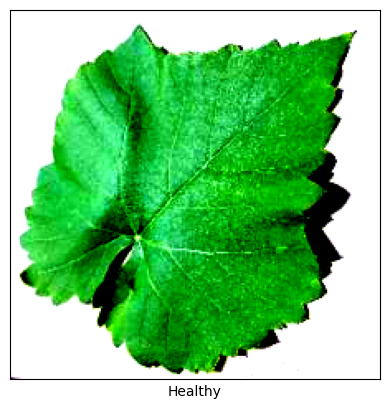

In [8]:
from PIL import Image
test_img_path = "/Users/afflatus/Documents/UoM_MSc/Diss/Data/Augmentation/Grape/Healthy/image (1).JPG"

img = Image.open(test_img_path)


img1 = transformation(img)
mobile_model.to(device)
display_img(img1, predict(mobile_model, test_img_path, device), classes)

In [9]:
classes

['Black_rot',
 'Esca_(Black_Measles)',
 'Healthy',
 'Leaf_blight_(Isariopsis_Leaf_Spot)',
 'No_leaves']

### Convert Model into ML Model format for iOS App

In [10]:
mobile_model.to('cpu')
convert_to_mlmodel(mobile_model, classes, "grape_model",test_img_path) 

Running MIL default pipeline:   0%|          | 0/56 [00:00<?, ? passes/s]/Users/afflatus/opt/miniconda3/envs/diss/lib/python3.8/site-packages/coremltools/converters/mil/mil/passes/defs/preprocess.py:262: UserWarning: Output, '824', of the source model, has been renamed to 'var_824' in the Core ML model.
  warnings.warn(msg.format(var.name, new_name))
Translating MIL ==> NeuralNetwork Ops: 100%|██████████| 495/495 [00:01<00:00, 441.17 ops/s] 


-------------Convert successfully-------------------
Model saved at../ML_Models/grape_model.mlmodel
-------------Testing converted model----------------
Healthy
